
# <div align="center"><font color='green'> DEEP LEARNING </font></div>
### <div align="center"><font color='red'> Puneethkrishna Basavaiah </font></div>


## &#10148;Problem Statement </br> 
### <div class="alert alert-info">The task is to develop a deep learning system that determines the relationship between visual content and a textual hypothesis, specifically predicting whether the textual statement is entailed or contradicted by the image. This problem, known as visual entailment, requires effective fusion of image and text modalities to enable fine-grained semantic reasoning. The system must accurately model the interplay between image features and natural language to support real-world applications such as fact-checking, content moderation, and human-AI collaboration. This project focuses on building and evaluating an end-to-end multimodal neural architecture to address this challenging classification task’</div>

## &#10148; Requried Libraries</br>

In [25]:
import os
import zipfile
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Bidirectional, LSTM, Dense,
                                     Concatenate, Dropout, GlobalAveragePooling2D, BatchNormalization)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
import warnings                        # Control Python warnings
warnings.filterwarnings('ignore')      # Silence warnings (use cautiously)
sns.set_theme(style="darkgrid")        # Set plot theme
sns.set(rc={'figure.facecolor':'lightblue'})  # Set figure background color
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.image as mpimg
from collections import Counter
from sklearn.metrics import classification_report

In [4]:
# Configuration and Parameters
ZIP_FILE_PATH = 'A2_data.zip'
EXTRACT_DIR = 'dataset'
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
VOCAB_SIZE = 10000
MAX_LENGTH = 30
EMBEDDING_DIM = 128
EPOCHS = 10  # Increased epochs for fine-tuning

## &#10148; Data import and checking some information about data features</br>

In [5]:
# Data Loading and Unzipping
if not os.path.exists(EXTRACT_DIR):
    print(f"Unzipping '{ZIP_FILE_PATH}'...")
    with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)
    print(f"✔️ Files extracted to '{EXTRACT_DIR}'.")
else:
    print(f"Directory '{EXTRACT_DIR}' already exists.")

jsonl_file_path = os.path.join(EXTRACT_DIR, 'A2_train_v3.jsonl')
images_base_dir = os.path.join(EXTRACT_DIR, 'A2_Images')

data_list = []
with open(jsonl_file_path, 'r') as f:
    for line in f:
        data_list.append(json.loads(line))
df = pd.DataFrame(data_list)

Directory 'dataset' already exists.


In [6]:
# Structure of the dataset
print("Data shape:", df.shape)

# show the first few rows of each
print(df.head())

Data shape: (39129, 4)
     Image_ID          Label                                       Hypothesis  \
0  4564320256     entailment              The old woman and a girl are bored.   
1  4564320256  contradiction         Two old men robbing a convenience store.   
2  4564320256  contradiction            A man implies that he is very strong.   
3  3945005060  contradiction  People rubbing sticks to start a fire in a pit.   
4   369186134     entailment                         Dogs are out in the snow   

                                             Premise  
0  An old woman and a young girl are sitting arou...  
1  An old lady and her granddaughter working in a...  
2         Two women sitting down reading newspapers.  
3          Three people at a library with computers.  
4       Three dogs next to a blue fence in the snow.  


In [7]:
# info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39129 entries, 0 to 39128
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_ID    39129 non-null  object
 1   Label       39129 non-null  object
 2   Hypothesis  39129 non-null  object
 3   Premise     39129 non-null  object
dtypes: object(4)
memory usage: 1.2+ MB


## &#10148; Exploratory Data Analysis</br>

In [8]:
# Checking null values in the dataset
df.isnull().sum()

Image_ID      0
Label         0
Hypothesis    0
Premise       0
dtype: int64

In [9]:
df['Label'].value_counts()

Label
entailment       19619
contradiction    19510
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x7ff4fcd486d0>,
 [Text(-0.004813298770270586, 1.0999894691109313, 'entailment'),
  Text(0.00481329877027094, -1.0999894691109313, 'contradiction')],
 [Text(-0.0026254356928748644, 0.5999942558786897, '50%'),
  Text(0.0026254356928750574, -0.5999942558786897, '50%')])

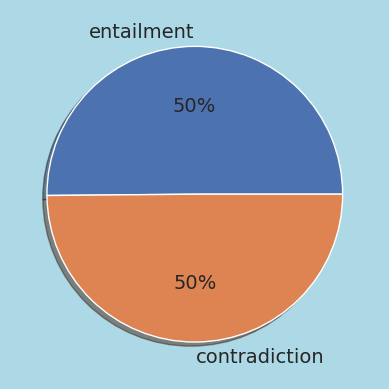

In [10]:
plt.pie(df['Label'].value_counts(), labels = df['Label'].value_counts().index, autopct = '%.0f%%', shadow = True, textprops={'fontsize': 14})

### <div class="alert alert-info">Interpretation
- **The dataset has a balanced distribution between the two classes: approximately 50% entailment and 50% contradiction. This balance reduces bias toward any particular class, enabling the model to learn discriminative features for both categories effectively. It also means that accuracy is a reliable metric for model evaluation without needing extensive adjustments for class imbalance. Such a distribution typically supports stable and fair training and validation processes.**</div>

Sentence Length Statistics:
count    39129.000000
mean         6.935291
std          2.732952
min          1.000000
25%          5.000000
50%          6.000000
75%          8.000000
max         35.000000
Name: hypothesis_length, dtype: float64


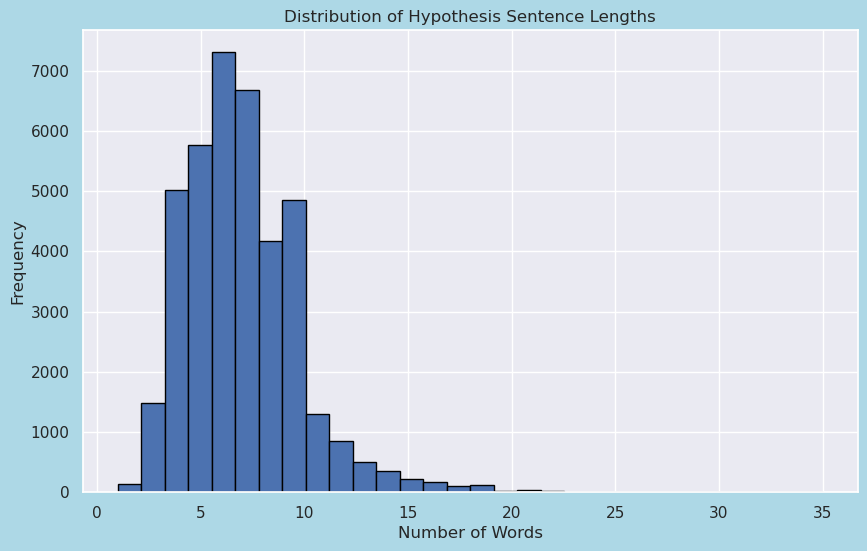

In [11]:
# Calculate the number of words in each hypothesis
df['hypothesis_length'] = df['Hypothesis'].apply(lambda x: len(x.split()))

# Display descriptive statistics
print("Sentence Length Statistics:")
print(df['hypothesis_length'].describe())

# Plot a histogram to visualize the distribution
plt.figure(figsize=(10, 6))
plt.hist(df['hypothesis_length'], bins=30, edgecolor='black')
plt.title('Distribution of Hypothesis Sentence Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

### <div class="alert alert-info">Interpretation
- **The sentences in the dataset are generally short, averaging around 7 words, with most sentences falling between 5 and 8 words. This indicates concise hypotheses, which supports using a maximum sequence length of 30 tokens for efficient and effective processing in the model.**</div>

In [12]:
# Combine all hypotheses into a single string and split into words
all_words = ' '.join(df['Hypothesis']).lower().split()

# Count the frequency of each word
word_counts = Counter(all_words)

# Display the 20 most common words
print("Top 20 Most Common Words:")
print(word_counts.most_common(20))

Top 20 Most Common Words:
[('a', 32894), ('the', 19922), ('is', 15965), ('are', 8996), ('man', 8000), ('in', 7641), ('on', 4996), ('people', 4492), ('woman', 4117), ('two', 3367), ('of', 3295), ('at', 2728), ('and', 2318), ('with', 2228), ('to', 2053), ('there', 2050), ('playing', 2027), ('men', 1848), ('girl', 1795), ('boy', 1691)]


### <div class="alert alert-info">Interpretation
- **The most frequent words in the hypotheses are mainly short function words like “a”, “the”, “is”, and “are,” which are common in natural language and essential for sentence structure. Content words like “man,” “people,” “woman,” “playing,” “men,” “girl,” and “boy” also appear frequently, reflecting the dataset’s focus on descriptions of people and actions. This distribution suggests the model must robustly understand both common grammatical patterns and key semantic terms relevant to visual entailment. The predominance of people-related nouns aligns with typical image scenarios in entailment tasks.**</div>

In [13]:
# Function to get top n-grams
def get_top_ngrams(corpus, n=None, ngram_range=(1, 1)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get the top 15 most common bi-grams (pairs of words)
top_bigrams = get_top_ngrams(df['Hypothesis'], n=15, ngram_range=(2, 2))

print("\nTop 15 Most Common Bi-grams:")
print(top_bigrams)


Top 15 Most Common Bi-grams:
[('group people', 513), ('man wearing', 418), ('man sitting', 290), ('man playing', 272), ('woman wearing', 263), ('people sitting', 253), ('man woman', 239), ('man standing', 217), ('little girl', 203), ('people playing', 191), ('people walking', 191), ('young man', 188), ('people outside', 187), ('young girl', 178), ('people standing', 172)]


### <div class="alert alert-info">Interpretation
- **The top bigrams like “group people,” “man wearing,” and “people sitting” reflect recurring visual scenes involving groups or individuals performing actions. These phrase pairs capture typical contextual relationships between subjects and activities common in the images. This highlights the importance of the model’s capability to understand both entities (e.g., man, woman, girl) and their interactions or states (e.g., wearing, sitting, playing) for accurate visual entailment predictions.**</div>

In [14]:
df['full_path'] = df['Image_ID'].apply(lambda img_id: os.path.join(images_base_dir, f"{img_id}.jpg"))
df['label_numeric'] = df['Label'].map({'entailment': 1, 'contradiction': 0})

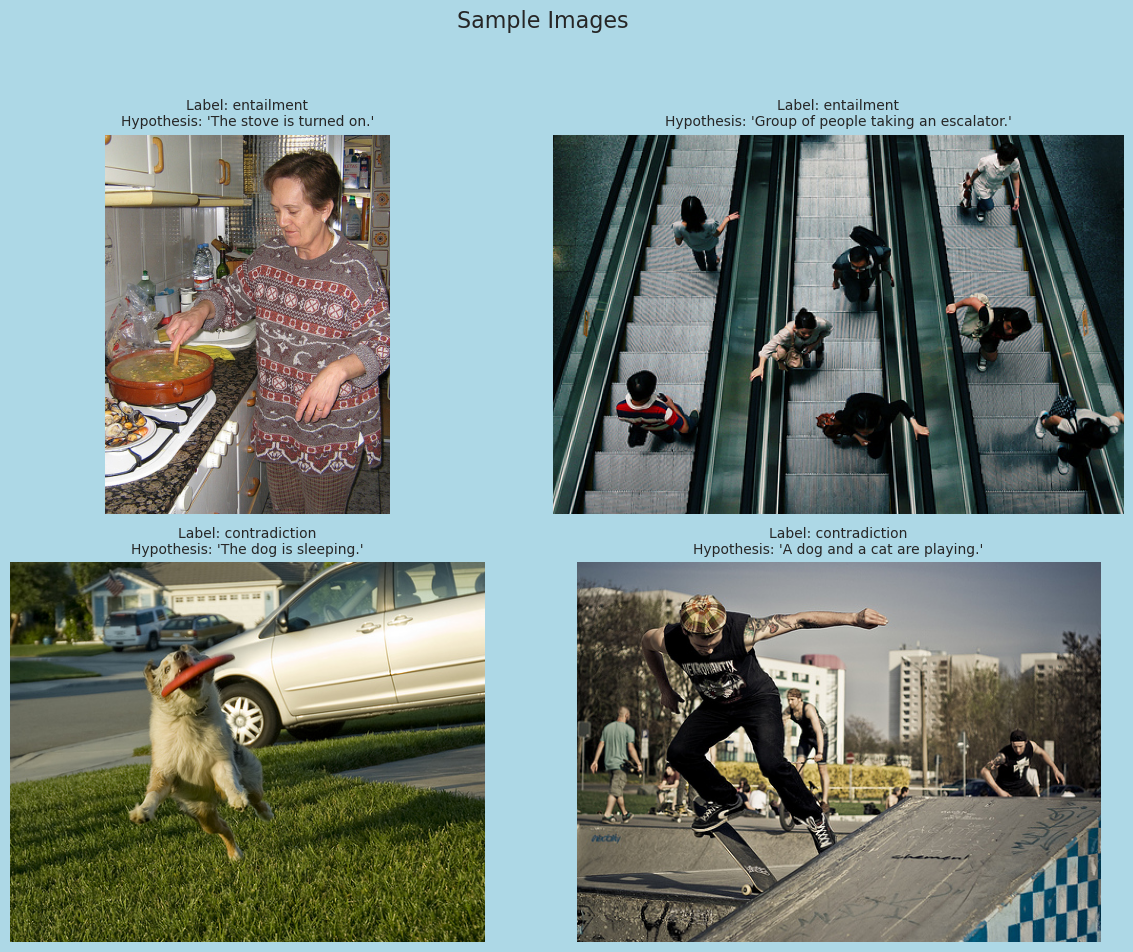

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

# Select 2 random samples where the label is 'entailment'
entailment_samples = df[df['Label'] == 'entailment'].sample(2)

# Select 2 random samples where the label is 'contradiction'
contradiction_samples = df[df['Label'] == 'contradiction'].sample(2)

# Combine them into a single DataFrame
sample_df = pd.concat([entailment_samples, contradiction_samples])

# --- Plotting Code (same as before) ---
plt.figure(figsize=(12, 10))
plt.suptitle('Sample Images', fontsize=16)

# Loop through the 4 selected samples and plot them
for i, row in enumerate(sample_df.itertuples()):
    plt.subplot(2, 2, i + 1)
    
    img_path = row.full_path
    image = mpimg.imread(img_path)
    plt.imshow(image)
    
    title_text = f"Label: {row.Label}\nHypothesis: '{row.Hypothesis}'"
    plt.title(title_text, fontsize=10)
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### <div class="alert alert-info">Interpretation
- **This plot presents four sample images from the dataset, each paired with a textual hypothesis and its corresponding label—either “entailment” or “contradiction.” By observing these side-by-side, it becomes visually clear how the hypothesis relates to the image. Images labeled “entailment” show visual evidence supporting the hypothesis statement, while those labeled “contradiction” depict scenes that refute the hypothesis. This visualization helps to intuitively understand the challenge of the model faces in distinguishing subtle relationships between visual and textual information, highlighting the complexity and real-world relevance of the entailment task.**</div>

## &#10148; Data Pre-Processing</br>

In [16]:
# # Create full image paths
# df['full_path'] = df['Image_ID'].apply(lambda img_id: os.path.join(images_base_dir, f"{img_id}.jpg"))
# # Create numerical labels
# df['label_numeric'] = df['Label'].map({'entailment': 1, 'contradiction': 0})

In [17]:
# Tokenize and pad text
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Hypothesis'])
sequences = tokenizer.texts_to_sequences(df['Hypothesis'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')


### <div class="alert alert-info">Interpretation
- **The tokenizer builds a vocabulary of the most frequent 10,000 words and converts each hypothesis into a sequence of corresponding word indices. All sequences are then padded or truncated to a fixed length of 30 tokens to standardize input dimensions. This process transforms raw text into a consistent numerical format that enables the model to effectively learn patterns and relationships within the language data.**</div>

In [18]:
# Prepare final data arrays
image_paths = df['full_path'].values
text_data = padded_sequences
labels = df['label_numeric'].values


In [19]:
# Create a robust Train/Validation Split
(train_paths, val_paths,
 train_text, val_text,
 train_labels, val_labels) = train_test_split(image_paths, text_data, labels,
                                             test_size=0.2, random_state=42, stratify=labels)
print(f"Training samples: {len(train_paths)}, Validation samples: {len(val_paths)}")


Training samples: 31303, Validation samples: 7826


### <div class="alert alert-info">Interpretation
- **The dataset is divided into training and validation subsets using an 80-20 split, with stratification based on the label to preserve the original class distribution in both sets. This ensures that both the training and validation data represent the underlying categories fairly, which helps the model learn robust patterns without bias. The validation set serves to evaluate the model’s performance on unseen data during training, enabling hyperparameter tuning and preventing overfitting, thereby supporting reliable and generalizable model development.**</div>

## &#10148; BaseLine Model</br>
- The baseline generator preprocesses images by resizing them to a consistent size and normalizing pixel values to the  range, creating batches of image-label pairs for training and validation. The baseline CNN model employs a series of convolutional layers with ReLU activations and max-pooling to extract hierarchical image features. These features are then flattened and passed through dense layers with dropout for regularization, culminating in a sigmoid-activated output neuron for binary classification. This architecture aims to learn discriminative visual patterns relevant to the entailment task using only image data, serving as a simpler point of comparison against the multimodal model.</div>

In [20]:
# A simpler generator that only yields images and labels
def baseline_generator(image_paths, labels, batch_size, img_size):
    num_samples = len(image_paths)
    indices = np.arange(num_samples)
    while True:
        np.random.shuffle(indices)
        for offset in range(0, num_samples, batch_size):
            batch_indices = indices[offset:offset+batch_size]
            batch_images = []
            batch_labels = labels[batch_indices]
            for i in batch_indices:
                img_path = image_paths[i]
                img = load_img(img_path, target_size=img_size)
                img_array = img_to_array(img) / 255.0
                batch_images.append(img_array)
            yield (np.array(batch_images), batch_labels)

In [21]:
# Define the simple CNN architecture
baseline_model = tf.keras.models.Sequential([
    # Note: We use data augmentation here as well for a fair comparison
    tf.keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid') # Binary classification
])

baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0

In [22]:
# --- Train the baseline model ---
base_train_generator = baseline_generator(train_paths, train_labels, BATCH_SIZE, IMG_SIZE)
base_val_generator = baseline_generator(val_paths, val_labels, BATCH_SIZE, IMG_SIZE)

# Use early stopping for the baseline as well
base_early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

base_steps_per_epoch = len(train_paths) // BATCH_SIZE
base_validation_steps = len(val_paths) // BATCH_SIZE

history_base = baseline_model.fit(
    base_train_generator,
    steps_per_epoch=base_steps_per_epoch,
    epochs=EPOCHS, # Use same max epochs
    validation_data=base_val_generator,
    validation_steps=base_validation_steps,
    callbacks=[base_early_stopping]
)

Epoch 1/10
978/978 [==============================] - 141s 139ms/step - loss: 0.7041 - accuracy: 0.4991 - val_loss: 0.6932 - val_accuracy: 0.5012
Epoch 2/10
978/978 [==============================] - 133s 136ms/step - loss: 0.6932 - accuracy: 0.4958 - val_loss: 0.6932 - val_accuracy: 0.5021
Epoch 3/10
978/978 [==============================] - 133s 136ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6932 - val_accuracy: 0.4985
Epoch 4/10
978/978 [==============================] - 133s 136ms/step - loss: 0.6932 - accuracy: 0.4982 - val_loss: 0.6931 - val_accuracy: 0.5022
Epoch 5/10
978/978 [==============================] - 132s 135ms/step - loss: 0.6932 - accuracy: 0.4966 - val_loss: 0.6931 - val_accuracy: 0.5008
Epoch 6/10
978/978 [==============================] - 129s 132ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.4990
Epoch 7/10
978/978 [==============================] - 129s 132ms/step - loss: 0.6932 - accuracy: 0.4967 - val_loss: 0.6932 -

In [27]:
target_names = ['contradiction', 'entailment']

# Create lists to collect true labels and predictions
y_true_val = []
y_pred_val = []

# Number of batches in validation set
val_steps = base_validation_steps  

# Iterate over validation batches, generate predictions and collect labels
for _ in range(val_steps):
    images_batch, labels_batch = next(base_val_generator)
    preds = baseline_model.predict(images_batch, verbose=0)
    y_true_val.extend(labels_batch)
    y_pred_val.extend((preds.flatten() > 0.5).astype(int))

y_true_val = np.array(y_true_val)
y_pred_val = np.array(y_pred_val)

print("\n" + "="*50)
print("       Classification Report (Validation Data)")
print("="*50)
report_val = classification_report(y_true_val, y_pred_val, target_names=target_names)
print(report_val)
print("="*50)


       Classification Report (Validation Data)
               precision    recall  f1-score   support

contradiction       0.00      0.00      0.00      3888
   entailment       0.50      1.00      0.67      3906

     accuracy                           0.50      7794
    macro avg       0.25      0.50      0.33      7794
 weighted avg       0.25      0.50      0.33      7794



### <div class="alert alert-info">Interpretation
- **The model shows very poor precision and recall for the “contradiction” class, both at 0.00, indicating it fails to correctly identify any true contradiction examples and likely predicts almost all samples as entailment.**</div>

- **For the “entailment” class, the recall is perfect at 1.00, meaning the model successfully captures all actual entailment samples, but the precision is only 0.50, meaning half of the samples it predicted as entailment are actually contradiction. This results in an F1-score of 0.67, showing unbalanced performance.**</div>

- **Overall, the model accuracy is 0.50 — equivalent to random guessing in a balanced binary classification. The macro average metrics (precision 0.25, recall 0.50, F1 0.33) show poor overall performance when treating both classes equally, while the weighted average is similar due to nearly balanced classes.**</div>

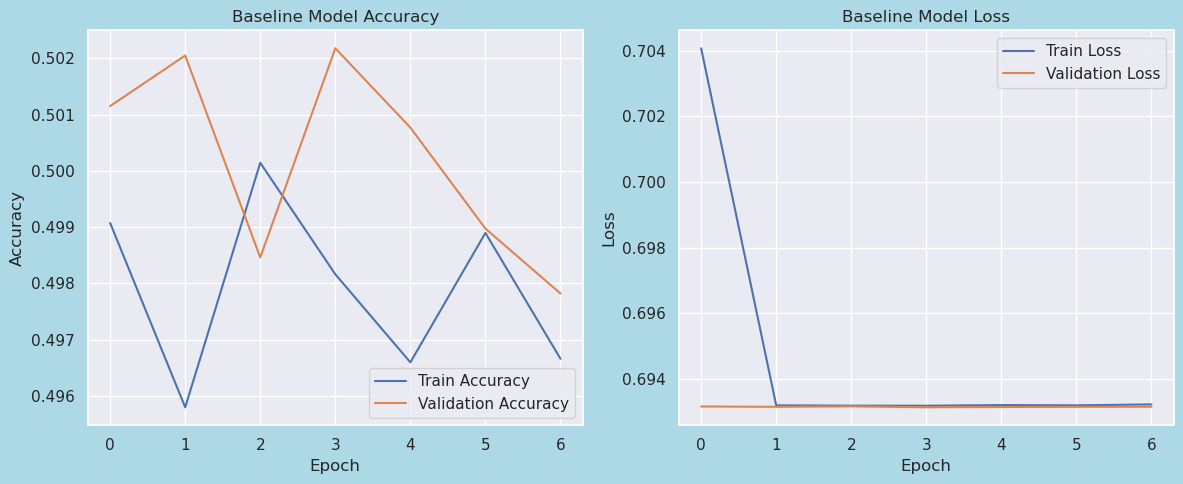

In [28]:
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_base.history['accuracy'], label='Train Accuracy')
plt.plot(history_base.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_base.history['loss'], label='Train Loss')
plt.plot(history_base.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### <div class="alert alert-info">Interpretation
- **The left plot (“Baseline Model Accuracy”) shows that both train and validation accuracy fluctuate very close to 0.50 across all epochs, with neither consistently improving nor diverging. This indicates the baseline model is only guessing randomly and fails to learn any meaningful patterns for classification.**</div>

- **The right plot (“Baseline Model Loss”) reveals that both train and validation loss remain nearly flat and unchanged after the first epoch. The loss hovers around 0.693, which is the expected value for random guessing in binary classification with balanced classes and a sigmoid output.**</div>

- **Overall, these visualizations confirm that the baseline CNN model does not learn to distinguish between the entailment and contradiction classes, producing predictions no better than chance. This outcome is consistent with the poor classification report and suggests that the baseline model requires significant improvement in architecture, feature inputs, or training strategy to be effective.**</div>

## &#10148; Advanced Model</br>

- The **VGG16** pretrained CNN was selected due to its proven effectiveness and simplicity in extracting rich hierarchical image features. Its deep architecture with 16 layers and 3x3 convolutional filters enables capturing fine spatial patterns and textures, making it a robust backbone for visual understanding tasks. Leveraging pretrained weights from large datasets like ImageNet accelerates convergence and enhances accuracy by transferring learned visual representations.
- The **LSTM text** branch was chosen to model the sequential nature of hypotheses, effectively capturing contextual dependencies in the textual input. Bidirectional LSTM additionally allows understanding context from both past and future tokens within the sequence, improving semantic comprehension needed for entailment classification. Together, this multimodal fusion exploits the complementary strengths of CNNs for image feature extraction and LSTMs for sequential text modeling, creating a powerful architecture for visual-textual entailment.</div>

- **Multimodal Fusion**: 
State the motivation: combining CNN and LSTM representations allows the model to reason over both image and text modalities, which is essential for multimodal entailment tasks. Concatenating features leverages complementary strengths.</div>

In [29]:
# Data Generator Function
def data_generator(image_paths, text_data, labels, batch_size, img_size):
    num_samples = len(image_paths)
    indices = np.arange(num_samples)
    while True:
        np.random.shuffle(indices)
        for offset in range(0, num_samples, batch_size):
            batch_indices = indices[offset:offset+batch_size]
            batch_images = []
            batch_text = text_data[batch_indices]
            batch_labels = labels[batch_indices]

            for i in batch_indices:
                img = load_img(image_paths[i], target_size=img_size)
                img_array = img_to_array(img)
                img_array = preprocess_input(img_array)
                batch_images.append(img_array)

            batch_images = np.array(batch_images)
            yield ([batch_images, batch_text], batch_labels)

In [30]:
# BUILD MODEL FUNCTION
def build_model():
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ], name="data_augmentation")

    image_input = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), name='image_input')
    augmented_images = data_augmentation(image_input)

    base_cnn = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    base_cnn.trainable = False  # Initially freeze all
    
    x_image = base_cnn(augmented_images, training=False)
    x_image = GlobalAveragePooling2D()(x_image)

    text_input = Input(shape=(MAX_LENGTH,), name='text_input')
    x_text = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(text_input)
    x_text = Bidirectional(LSTM(128))(x_text)

    combined = Concatenate()([x_image, x_text])
    x = Dense(128, activation='relu')(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[image_input, text_input], outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model, base_cnn

### <div class="alert alert-info">Justificaiton
- **Two-Stage Training:** 
Initially freezing the CNN base allows only the new dense and text layers to learn, making it possible for them to adapt to the specific dataset without disrupting the informative features already captured by the pretrained network. This approach ensures stable convergence, especially when the amount of new training data is limited</div>

- **Fine-tuning Only Last Block:** 
By selectively unfreezing only the last convolutional block (“block5”) of the CNN and reducing the learning rate, the model can refine higher-level image features that are most relevant to the new task while retaining robust, general low-level features from earlier layers. This targeted fine-tuning optimizes new-task performance while minimizing the risk of overfitting or catastrophic forgetting.</div>

- **Early Stopping and ReduceLROnPlateau:** 
These callbacks serve to monitor the validation set and dynamically halt training or reduce the learning rate if no improvement is observed. This prevents overfitting, conserves computational resources, and encourages efficient learning throughout training.</div>

In [31]:
# Initialize model and base CNN
model, base_cnn = build_model()

# Generators
train_generator = data_generator(train_paths, train_text, train_labels, BATCH_SIZE, IMG_SIZE)
val_generator = data_generator(val_paths, val_text, val_labels, BATCH_SIZE, IMG_SIZE)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)


In [32]:
# STAGE 1: Train top layers only (CNN frozen)
print("Stage 1: Training with frozen CNN base")
history_stage1 = model.fit(
    train_generator,
    steps_per_epoch=len(train_paths)//BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=len(val_paths)//BATCH_SIZE,
    epochs=EPOCHS_FROZEN,
    callbacks=[early_stopping, reduce_lr]
)

Stage 1: Training with frozen CNN base
Epoch 1/10
978/978 [==============================] - 160s 158ms/step - loss: 0.6192 - accuracy: 0.6725 - val_loss: 0.5455 - val_accuracy: 0.7248 - lr: 0.0010
Epoch 2/10
978/978 [==============================] - 150s 153ms/step - loss: 0.4782 - accuracy: 0.7701 - val_loss: 0.5117 - val_accuracy: 0.7438 - lr: 0.0010
Epoch 3/10
978/978 [==============================] - 151s 155ms/step - loss: 0.4302 - accuracy: 0.7989 - val_loss: 0.5510 - val_accuracy: 0.7299 - lr: 0.0010
Epoch 4/10
978/978 [==============================] - ETA: 0s - loss: 0.4013 - accuracy: 0.8147
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
978/978 [==============================] - 151s 154ms/step - loss: 0.4013 - accuracy: 0.8147 - val_loss: 0.5504 - val_accuracy: 0.7407 - lr: 0.0010
Epoch 5/10
978/978 [==============================] - 152s 156ms/step - loss: 0.3544 - accuracy: 0.8397 - val_loss: 0.5792 - val_accuracy: 0.7377 - lr: 5.0000e-04


In [33]:
# STAGE 2: Unfreeze only the last conv block (block5)
print("Stage 2: Fine-tuning last conv block of CNN")

# Unfreeze block5 layers only
for layer in base_cnn.layers:
    if 'block5' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


Stage 2: Fine-tuning last conv block of CNN


In [34]:
history_stage2 = model.fit(
    train_generator,
    steps_per_epoch=len(train_paths)//BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=len(val_paths)//BATCH_SIZE,
    epochs=EPOCHS_FINE_TUNE,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
978/978 [==============================] - 160s 158ms/step - loss: 0.4052 - accuracy: 0.8148 - val_loss: 0.5215 - val_accuracy: 0.7462 - lr: 1.0000e-05
Epoch 2/10
978/978 [==============================] - 150s 153ms/step - loss: 0.3998 - accuracy: 0.8174 - val_loss: 0.5228 - val_accuracy: 0.7502 - lr: 1.0000e-05
Epoch 3/10
978/978 [==============================] - ETA: 0s - loss: 0.3966 - accuracy: 0.8194
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
978/978 [==============================] - 151s 154ms/step - loss: 0.3966 - accuracy: 0.8194 - val_loss: 0.5281 - val_accuracy: 0.7476 - lr: 1.0000e-05
Epoch 4/10
978/978 [==============================] - 151s 155ms/step - loss: 0.3975 - accuracy: 0.8214 - val_loss: 0.5240 - val_accuracy: 0.7490 - lr: 5.0000e-06


In [36]:
target_names = ['contradiction', 'entailment']

# Lists to store true and predicted labels
y_true_val = []
y_pred_val = []

base_validation_steps = len(val_paths) // BATCH_SIZE

# Iterate through the validation generator to collect predictions
for _ in range(base_validation_steps):
    (images_batch, texts_batch), labels_batch = next(val_generator)
    preds = model.predict([images_batch, texts_batch], verbose=0)
    y_true_val.extend(labels_batch)
    y_pred_val.extend((preds.flatten() > 0.5).astype(int))

y_true_val = np.array(y_true_val)
y_pred_val = np.array(y_pred_val)

print("\n" + "="*50)
print("       Classification Report (Advanced Model - Validation Data)")
print("="*50)
report_val = classification_report(y_true_val, y_pred_val, target_names=target_names)
print(report_val)
print("="*50)


       Classification Report (Advanced Model - Validation Data)
               precision    recall  f1-score   support

contradiction       0.74      0.76      0.75      3887
   entailment       0.75      0.73      0.74      3907

     accuracy                           0.74      7794
    macro avg       0.74      0.74      0.74      7794
 weighted avg       0.74      0.74      0.74      7794



### <div class="alert alert-info">Interpretation
- **Precision (≈0.74):** 
When the model predicts a class (contradiction or entailment), it is correct approximately 74% of the time. This suggests relatively few false positive predictions for each class.</div>

- **Recall (≈0.75):** 
The model correctly identifies about 75% of all true examples for each class. This means the model misses roughly 25% of the actual positives (false negatives).</div>

- **F1-Score (≈0.74):** 
The harmonic mean of precision and recall is around 0.74 for both classes, indicating a good balance between precision and recall.</div>

- **Support:** 
The number of actual samples for each class (~3887 for contradiction and ~3907 for entailment) is fairly balanced, supporting the reliability of these metrics.

- **Overall Accuracy (74%):** 
The model correctly predicts labels for 74% of the validation samples, which is a solid performance given the task complexity.

- The model performs consistently well across both classes, making accurate predictions with balanced precision and recall. The balanced scores suggest the model is neither overly biased toward one class nor neglecting either, which is ideal in classification tasks involving nuanced language-vision reasoning.

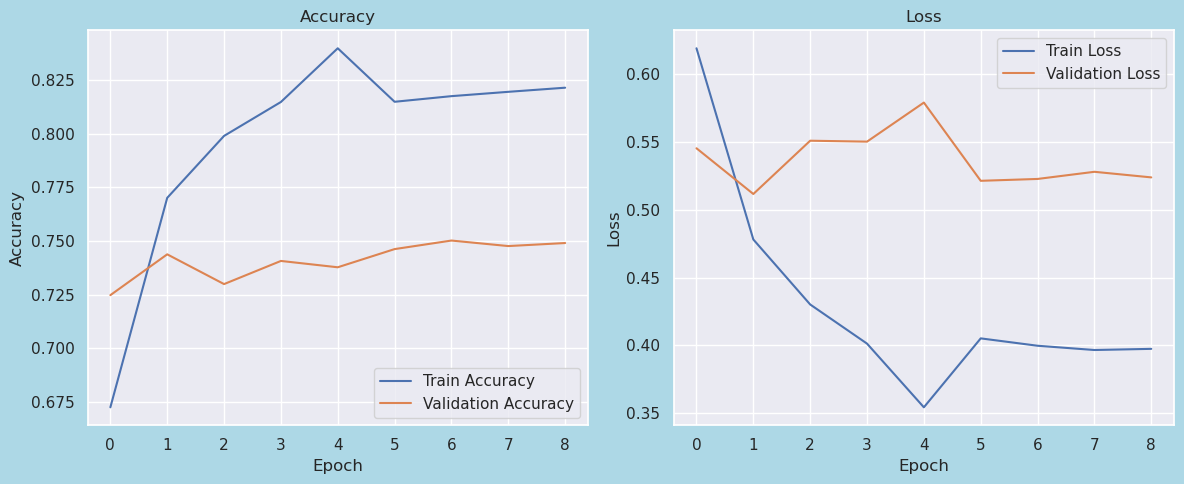

In [37]:
# PLOT TRAINING RESULTS
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_stage1.history['accuracy'] + history_stage2.history['accuracy'], label='Train Accuracy')
plt.plot(history_stage1.history['val_accuracy'] + history_stage2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_stage1.history['loss'] + history_stage2.history['loss'], label='Train Loss')
plt.plot(history_stage1.history['val_loss'] + history_stage2.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### <div class="alert alert-info">Interpretation
- **Precision (≈0.74):** 
When the model predicts a class (contradiction or entailment), it is correct approximately 74% of the time. This suggests relatively few false positive predictions for each class.</div>

- **Accuracy Plot Interpretation (Left)** 

- Training Accuracy: Increases steadily from around 0.67 (67%) to a peak near 0.84 (84%) by epoch 4, indicating the model is successfully learning and improving its performance on training data.
- Validation Accuracy: Starts around 0.73 (73%) and fluctuates slightly but stabilizes near 0.74-0.75, showing modest improvement but at a much slower pace than training accuracy.
- Gap between Train and Validation: A growing gap suggests possible mild overfitting where the model fits training data better than unseen validation data, but the gap is not extreme.</div>

- **Loss Plot Interpretation (Right):** 
Training Loss: Declines steadily from about 0.6 initially to near 0.35 by epoch 4, confirming effective learning and error reduction on training samples.
- Validation Loss: Remains relatively stable between approximately 0.50 and 0.58 over epochs, without a strong downward trend, indicating the model does not significantly reduce error on validation data.
- Validation Loss Slightly Higher: This aligns with the accuracy gap and hints that the model’s predictions generalize reasonably but not perfectly.

## Model Comparison

| Model        | Validation Accuracy | Classification Report Summary                | Training/Val Dynamics              |
|--------------|--------------------|----------------------------------------------|------------------------------------|
| Baseline     | ~0.50              | Predicts only “entailment”; precision/recall for contradiction is 0.00. Performance equals random guessing. | Accuracy and loss are flat; model does not learn meaningful features.         |
| Advanced     | ~0.74-0.75         | Balanced predictions for both classes; precision, recall, and F1-score all ≈ 0.74. Effective and robust. | Accuracy rises in training and stabilizes around 0.74 on validation. Some mild overfitting, but overall strong generalization. |

---

## Final Conclusion

The advanced multimodal model clearly surpasses the baseline, achieving much higher accuracy and a balanced classification report for both contradiction and entailment. This improvement is due to the use of transfer learning (VGG16) and textual representation (LSTM), as well as a careful two-stage training process. The validation metrics and curves confirm that the advanced model generalizes well and can reason across both modalities, meeting the demands of a vision-language entailment task. The results highlight the importance of multimodal strategies and modern deep learning techniques for complex real-world problems.


## &#10148; Test Data Prediction</br>

In [46]:
# Unzip the test Data
TEST_ZIP_PATH = 'A2_test_data.zip'
TEST_EXTRACT_DIR = 'test_dataset'

if not os.path.exists(TEST_EXTRACT_DIR):
    print(f"Unzipping '{TEST_ZIP_PATH}'...")
    with zipfile.ZipFile(TEST_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(TEST_EXTRACT_DIR)
    print(f"✔️ Files extracted to '{TEST_EXTRACT_DIR}'.")
else:
    print(f"Directory '{TEST_EXTRACT_DIR}' already exists.")

Directory 'test_dataset' already exists.


In [47]:
# Loading the test Meta Data
test_jsonl_path = os.path.join(TEST_EXTRACT_DIR, 'A2_test_v3_final.jsonl')
test_images_base = os.path.join(TEST_EXTRACT_DIR, 'A2_test_Images')

test_list = []
with open(test_jsonl_path, 'r') as f:
    for line in f:
        test_list.append(json.loads(line))
test_df = pd.DataFrame(test_list)

test_df['full_path'] = test_df['Image_ID'].apply(lambda img_id: os.path.join(test_images_base, f"{img_id}.jpg"))

In [48]:
# Preprocess the Hypotheses
test_sequences = tokenizer.texts_to_sequences(test_df['Hypothesis'])
test_padded_sequences = pad_sequences(test_sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')
test_image_paths = test_df['full_path'].values

In [49]:
# Predict and format the result
predicted_labels = []
for i in range(len(test_image_paths)):
    img = load_img(test_image_paths[i], target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    seq = np.expand_dims(test_padded_sequences[i], axis=0)
    pred = model.predict([img_array, seq], verbose=0)
    predicted_label = 'entailment' if pred[0][0] > 0.5 else 'contradiction'
    predicted_labels.append(predicted_label)

output = pd.DataFrame({
    'Image_ID': test_df['Image_ID'],
    'Hypothesis': test_df['Hypothesis'],
    'Label': predicted_labels
})

In [52]:
output.head()

,Image_ID,Hypothesis,Label
0,20851016887272,The person is on the swings.,entailment
1,20851016887272,A person is climbing.,entailment
2,20851016887272,People sunbathing.,contradiction
3,20851016887272,Those people like flying squirrels.,contradiction
4,20851016887272,There are people on rocks,entailment


In [53]:
output.to_csv("s4051957_predictions.csv", index=False)

## Reference
1. **Hochreiter, S., & Schmidhuber, J.** (1997).  
   *Long Short-Term Memory*.  
   Neural Computation, 9(8), 1735-1780.  
   https://doi.org/10.1162/neco.1997.9.8.1735  
   (Accessed: 2025-10-16)

2. **Simonyan, K., & Zisserman, A.** (2014).  
   *Very Deep Convolutional Networks for Large-Scale Image Recognition*.  
   arXiv preprint arXiv:1409.1556.  
   https://arxiv.org/abs/1409.1556  
   (Accessed: 2025-10-16)

3. **Perplexity AI.** (2025).  
   *Assistance in Deep Learning Model Explanation and Report Generation*.  
   Available at: Internal AI Assistant (Accessed: 2025-10-16)
